# Project for Algorithms in Bioinformatics
## ATAC-seq network
ATAC-seq measures the chromatin accesibility, giving information about where the chromatin is open for transcription factors to bind and regulate the transcription of genes. Through a process called footprinting  we can get the sequence where the transcription factor binds. This sequence can then be matched to motifs to predict which transcription factor that binds to the open region. The footprinting and motif matching can be done using the regulatory genomics toolbox. The open region can also be annotated with close genes to predict which gene that is regulated. To annotate a region with nearest gene the R-package CHIPseeker can be used.

The motif matching and annotation to genes are done outside of this project. Here, I start with two files: 1. peaks with matched motif and 2. peaks with nearest gene. Peaks refers to an open chromatin region. These files are put together to a network.

In [5]:
import pandas as pd
import numpy as np

#read data
motif = pd.read_csv('project_data/Activation_mpbs.bed',sep='\t', header=None).iloc[:,:5]
motif.columns = ['seqnames','start','end','motif','score']
target = pd.read_csv('project_data/Activation_nearest_gene.bed',sep='\t').loc[:,['seqnames','start','end','annotation','geneId']]

# only use promoter regions
target_promoters = target[target.annotation.str.contains('Promoter')]

# correct for that the start of peak for motif and gene differs with one base.
target_promoters.loc[:,'start'] = target_promoters.loc[:,'start']-1

# remove not peaks with no annotation
target_promoters = target_promoters.dropna()

# make network by combining motif and target gene on peak.
network = pd.merge(motif,target_promoters, how='inner',on=['seqnames','start','end'])
network.loc[:,'motif'] = network['motif'].str.split('.').str[2] # remove motifID from name
network.loc[:,'motif'] = network['motif'].str.split('::').str[0] # if several annotated TFs only keep first
network = network.loc[:,['motif','geneId']]
network.columns = ['TF', 'target']
network = network.drop_duplicates()
network.to_csv('ATAC_prior.csv',sep='\t', index=False)

print('Prior: edges=',len(network),'tfs=',len(np.unique(network.TF)),'targets=',len(np.unique(network.target)))
network.head()

Prior: edges= 58857 tfs= 550 targets= 2175


,TF,target
0,Klf1,DDX11L1
1,KLF5,DDX11L1
2,NRF1,DDX11L1
3,ZIC4,LINC01128
5,ZIC3,LINC01128


## Apply network inference method on RNA-seq data
I input normalised expression data. The method also need a list of potential transcription factors, which I downloaded from http://humantfs.ccbr.utoronto.ca/.

### Read data
I format the data so that all possible TFs are present in the expression data. Also all TFs and targets in the prior should be present in the expression data.

In [6]:
exp = pd.read_csv('project_data/exp_normalized.csv', sep='\t', index_col='Unnamed: 0')
tfs = pd.read_csv('/home/bioinf/Documents/comhub/data/human_transcription_factors.txt', header=None)
prior = pd.read_csv('ATAC_prior.csv',sep='\t')
tfs = [tf for tf in np.array(tfs).flatten() if tf in exp.columns]
prior = prior[prior.isin(exp.columns)].dropna()
prior = prior[prior.TF.isin(np.array(tfs).flatten())]
print('Prior: edges=',len(prior),'tfs=',len(np.unique(prior.TF)),'targets=',len(np.unique(prior.target)))

Prior: edges= 35513 tfs= 410 targets= 1780


### Network inference
I use a simple network inference method that ranks edges based on the absolute value of the Pearson correlation coefficient. I will do the network inference both without and with a prior, and compare the resulting networks. The prior is considered by multiplying the correlation value for all edges present in the prior with a weight, increasing the importance of those edges. I am also interested in how diffent weights on the prior edges affects the results. Therefor, I try 3 different weights on the prior edges: 1.2, 1.5 and 2.

In [7]:
def pcc(exp, tfs, prior=None, prior_weight=1.5, network_cutoff=100000):
    """
    Absolute value of the Pearson correlation coefficient (PCC)
    Regulator-target interactions are ranked based on the absolute value of the PCC.
    """
    tfs = np.array(tfs).flatten()
    tfs = [tf for tf in tfs if tf in exp.columns]
    tfs_index = np.where(np.isin(exp.columns,tfs) == True)[0]

    print('calculating pcc')
    corrmat = np.corrcoef(np.array(exp.T))
    corrmat = np.abs(corrmat[tfs_index,:])
    corrmat = pd.DataFrame(corrmat, index=tfs, columns=exp.columns)
    
    #prior
    if prior is not None: 
        prior.loc[:,'value'] = np.ones(len(prior))
        prior_mat = prior.pivot(index='TF', columns='target', values='value')
        prior_mat = prior_mat*prior_weight
        prior_mat = prior_mat.loc[corrmat.index,corrmat.columns].fillna(1)
        corrmat = prior_mat*corrmat

    print('making network')
    net = corrmat.reset_index().melt(id_vars=['index'])
    net.columns = ['TF', 'target', 'confidence']
    net = net[net.TF != net.target]
    net_sort = net.sort_values(by='confidence', ascending=False).iloc[:network_cutoff, :]

    return net_sort

In [8]:
net = pcc(exp, tfs, network_cutoff=10000)
net.to_csv('pcc_network.csv', header=None, index=False, sep='\t')

calculating pcc
making network


In [9]:
net_prior12 = pcc(exp, tfs, prior, prior_weight=1.2, network_cutoff=10000)
net_prior12.to_csv('pcc_network_prior_1.2.csv', header=None, index=False, sep='\t')
net_prior15 = pcc(exp, tfs, prior, prior_weight=1.5, network_cutoff=10000)
net_prior15.to_csv('pcc_network_prior_1.5.csv', header=None, index=False, sep='\t')
net_prior2 = pcc(exp, tfs, prior, prior_weight=2, network_cutoff=10000)
net_prior2.to_csv('pcc_network_prior_2.csv', header=None, index=False, sep='\t')

calculating pcc


/home/bioinf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


making network
calculating pcc
making network
calculating pcc
making network


## Network analysis

I start by calculating the outdegree distribution of both networks.

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
net_df = pd.read_csv('pcc_network.csv', header=None, sep='\t')
net = nx.from_pandas_edgelist(net_df, source = 0, target = 1)

In [12]:
net_prior12_df = pd.read_csv('pcc_network_prior_1.2.csv', header=None, sep='\t')
net_prior12 = nx.from_pandas_edgelist(net_prior12_df, source = 0, target = 1)
net_prior15_df = pd.read_csv('pcc_network_prior_1.5.csv', header=None, sep='\t')
net_prior15 = nx.from_pandas_edgelist(net_prior15_df, source = 0, target = 1)
net_prior2_df = pd.read_csv('pcc_network_prior_2.csv', header=None, sep='\t')
net_prior2 = nx.from_pandas_edgelist(net_prior2_df, source = 0, target = 1)

### Degree distribution

In [84]:
def plot_hist(degree_list, degree_list_prior12, degree_list_prior15, degree_list_prior2):
    color_pallet = "bright"
    plt.style.use('seaborn-ticks')
    sns.set_color_codes(color_pallet)
    fig, ax = plt.subplots(ncols=2, nrows=2, facecolor='w', edgecolor='k', figsize=(15, 10), dpi=75)
    plt.rc('font', size=28)
    plt.rc('ytick', labelsize=24)
    plt.rc('xtick', labelsize=24)

    ax[0,0].hist(degree_list, bins=100)
    ax[0,1].hist(degree_list_prior12, bins=100)
    ax[1,0].hist(degree_list_prior15, bins=100)
    ax[1,1].hist(degree_list_prior2, bins=100)

    ax[0,0].set(xlabel='degree', title='w/0 prior')
    ax[0,1].set(xlabel='degree', title='prior 1.2')
    ax[1,0].set(xlabel='degree', title='prior 1.5')
    ax[1,1].set(xlabel='degree', title='prior 2')

    plt.subplots_adjust(hspace=0.5)

    sns.despine()
    plt.show()
    return fig

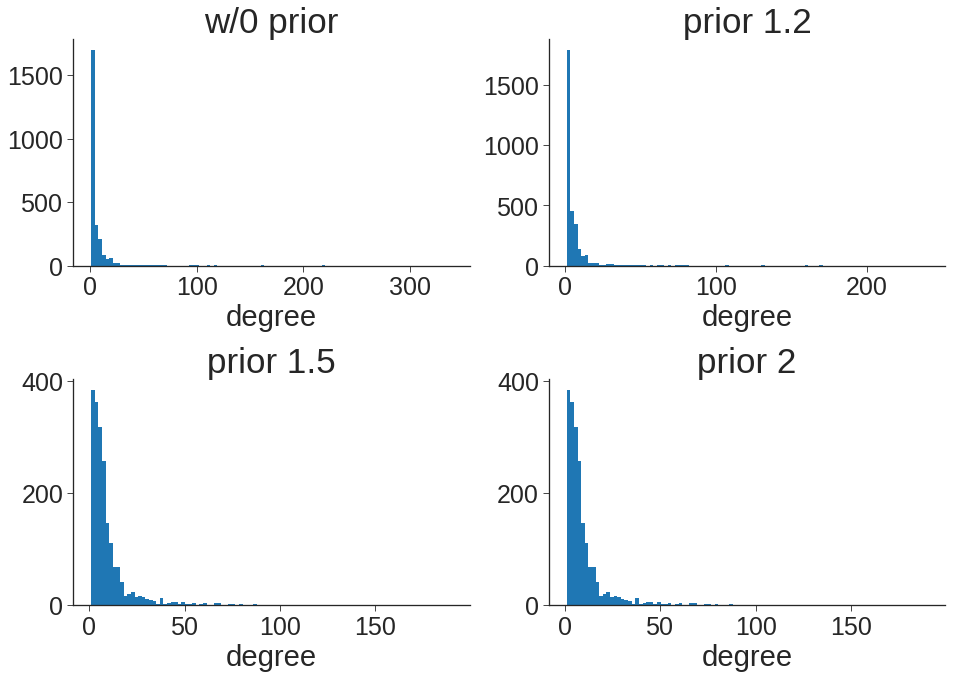

In [85]:
degree_list = [d for n, d in net.degree]
degree_list_prior12 = [d for n, d in net_prior12.degree]
degree_list_prior15 = [d for n, d in net_prior15.degree]
degree_list_prior2 = [d for n, d in net_prior2.degree]

fig = plot_hist(degree_list, degree_list_prior12, degree_list_prior15, degree_list_prior2)

Plot cumulative sum of outdegree

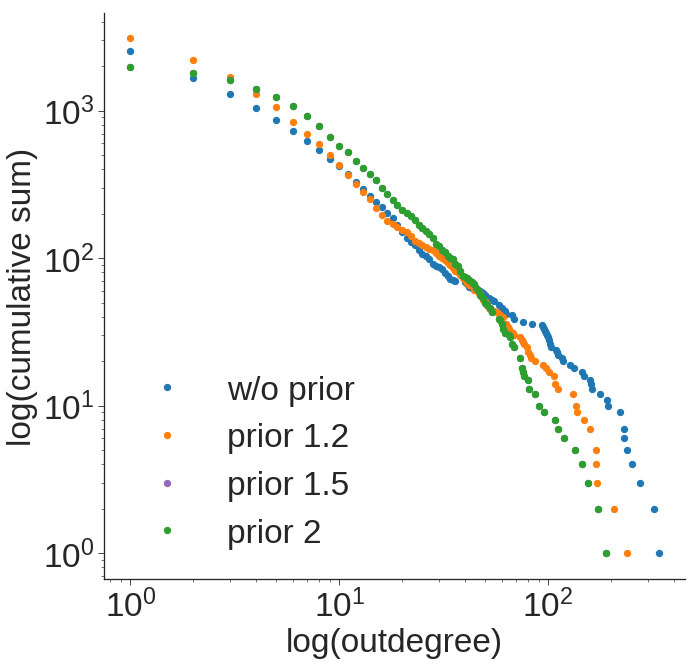

In [107]:
def outdegree_cumsum(net):
    TFoutdegree = pd.DataFrame(list(net.degree),columns=['TF','outdegree'])
    TFoutdegree['freq'] = TFoutdegree.groupby('outdegree')['outdegree'].transform('count')
    TFfreq = TFoutdegree.reset_index().loc[:,['outdegree','freq']].drop_duplicates().sort_values('outdegree', ascending=False)
    freq = np.cumsum(TFfreq.loc[:,'freq'])
    outdegree = TFfreq.loc[:,'outdegree']
    return freq, outdegree

freq, outdegree = outdegree_cumsum(net)
freq12, outdegree12 = outdegree_cumsum(net_prior12)
freq15, outdegree15 = outdegree_cumsum(net_prior15)
freq2, outdegree2 = outdegree_cumsum(net_prior2)

#Plot cumulative sum
color_pallet = "bright"
plt.style.use('seaborn-ticks')
sns.set_color_codes(color_pallet)
plt.rc('font', size=32)
plt.rc('ytick', labelsize=32)
plt.rc('xtick', labelsize=32)

fig, ax = plt.subplots(facecolor='w', edgecolor='k', figsize=(10,10), dpi=75)
ax.set_yscale('log')

ax.semilogx(outdegree, freq, 'C0.', markersize=12, linewidth=3, label='w/o prior')
ax.semilogx(outdegree12, freq12, 'C1.', markersize=12, linewidth=3, label='prior 1.2')
ax.semilogx(outdegree15, freq15, 'C4.', markersize=12, linewidth=3, label='prior 1.5')
ax.semilogx(outdegree2, freq2, 'C2.', markersize=12, linewidth=3, label='prior 2')

ax.set(xlabel='log(outdegree)', ylabel='log(cumulative sum)')
ax.legend()
sns.despine(offset=0, trim=False)


In [68]:
np.cumsum(TFfreq.sort_values('outdegree', ascending=False)['freq'])

27        1
26        2
71        3
78        4
99        5
22        6
45        7
64        9
85       10
32       11
254      12
140      13
110      14
125      15
235      16
163      17
23       18
12       19
239      20
500      21
221      22
318      23
146      24
335      25
194      26
187      28
93       29
310      30
52       31
251      32
       ... 
57       87
388      88
150      92
43       98
39      103
16      107
53      113
40      122
141     129
33      137
13      151
19      169
104     186
10      203
28      221
72      240
70      265
59      295
73      327
144     372
80      422
135     473
5       540
7       622
3       727
17      860
1      1039
38     1293
24     1657
11     2558
Name: freq, Length: 91, dtype: int64

### Identify hubs
Here, I consider TFs standing for 10% of the interactions in the networks to be hubs.

In [28]:
def get_hubs(net):
    TF_outdegrees = pd.DataFrame(list(net.degree)).sort_values(by=1, ascending=False)
    TF_outdegrees.index = TF_outdegrees[0]
    TF_outdegrees = TF_outdegrees.drop(0,1)
    hubs = TF_outdegrees[TF_outdegrees[1].cumsum() < TF_outdegrees[1].sum()*0.1]
    return hubs

In [29]:
hubs = get_hubs(net)
hubs_prior12 = get_hubs(net_prior12)
hubs_prior15 = get_hubs(net_prior15)
hubs_prior2 = get_hubs(net_prior2)

In [30]:
print(hubs)
print(hubs_prior12)
print(hubs_prior15)
print(hubs_prior2)

         1
0         
BATF   339
ZBED2  322
NFKB2  276
KLF3   253
RELB   239
PRDM1  232
NR4A3  230
         1
0         
BATF   240
NFKB2  208
ZBED2  171
KLF3   170
IRF1   169
RELB   159
PRDM1  159
IRF7   148
MAF    138
STAT1  136
RFX5   131
          1
0          
IRF1    190
ZNF384  174
STAT1   155
ZNF263  145
MZF1    135
MEF2A   119
MEF2D   112
SP1     108
IRF7     96
RREB1    90
POU2F2   87
KLF5     87
ZEB1     81
TCF3     80
RARA     80
FOSL2    77
TCF7L1   76
MEF2B    75
          1
0          
IRF1    190
ZNF384  174
STAT1   155
ZNF263  145
MZF1    135
MEF2A   119
MEF2D   112
SP1     108
IRF7     96
RREB1    90
POU2F2   87
KLF5     87
ZEB1     81
TCF3     80
RARA     80
FOSL2    77
TCF7L1   76
MEF2B    75


### Clustering coefficient
How densely connected is the network around each node.

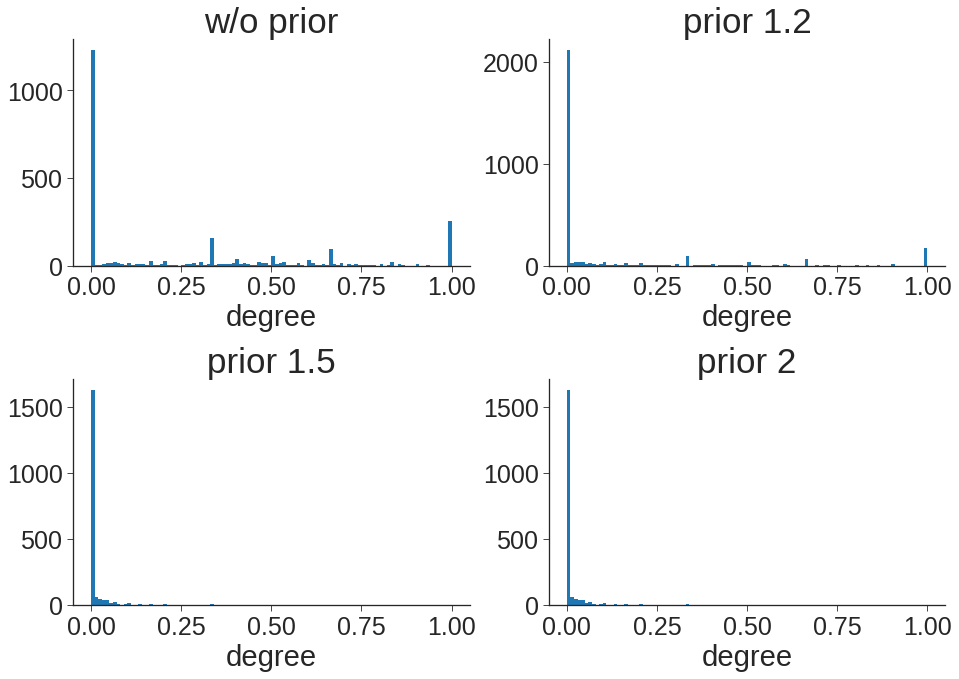

In [31]:
clustering_coeff =  [value for item, value in nx.clustering(net).items()]
clustering_coeff12 =  [value for item, value in nx.clustering(net_prior12).items()]
clustering_coeff15 =  [value for item, value in nx.clustering(net_prior15).items()]
clustering_coeff2 =  [value for item, value in nx.clustering(net_prior2).items()]

fig = plot_hist(clustering_coeff, clustering_coeff12, clustering_coeff15, clustering_coeff2)